In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch_geometric.nn import knn_graph
import torch_geometric.data as geom_data
from tqdm import tqdm
import networkx as nx
import torch_geometric as geom

In [2]:
data = np.load('./data/ep/raw/electron_photon.npz', allow_pickle = True)

In [3]:
x = data['x_test'][:100]
y = data['y_test'][:100]

x.shape, y.shape

((100, 32, 32, 1), (100,))

In [4]:
n_graphs = x.shape[0]

graphs = []
for idx in tqdm(range(n_graphs)):
    image = x[idx]
    label = torch.tensor([int(y[idx])], dtype=torch.int64)
    image = image.reshape(32,32)
    image = torch.tensor(image)

    x_hit,y_hit = torch.nonzero(image,as_tuple=True)  # Select hits in detector
    energy = image[x_hit, y_hit]*50

    # concatenate x,y locations and energies (3 features in total)
    node_feats = torch.stack((x_hit.float(),y_hit.float(),energy),dim=1) 
    coords = node_feats[:,[0,1]] # cords = x,y coordinates 

    if len(coords) == 0:
        continue

    # Create knn graph adjacency matrix
    edge_index = knn_graph(coords, k=4, batch=None, loop=True, num_workers=12) 

    # Create data object
    data = geom_data.Data(x=node_feats, 
                edge_index=edge_index,
                pos = coords,
                y=label)

    graphs.append(data)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 73.22it/s]


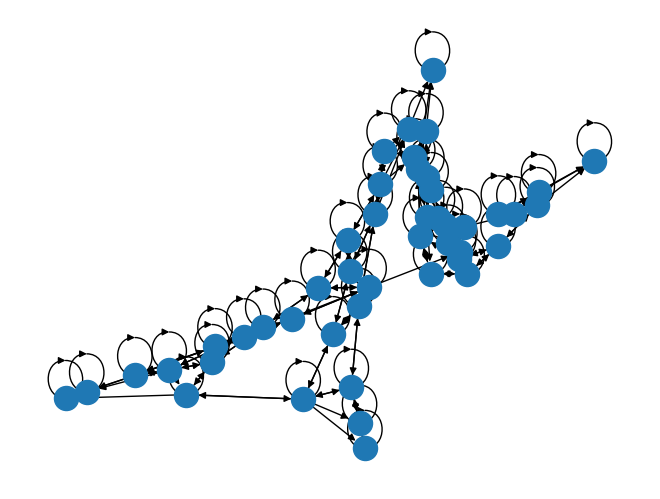

In [12]:
nx.draw(geom.utils.to_networkx(graphs[0]))

In [13]:
graphs[0]

Data(x=[46, 3], edge_index=[2, 184], y=[1], pos=[46, 2])

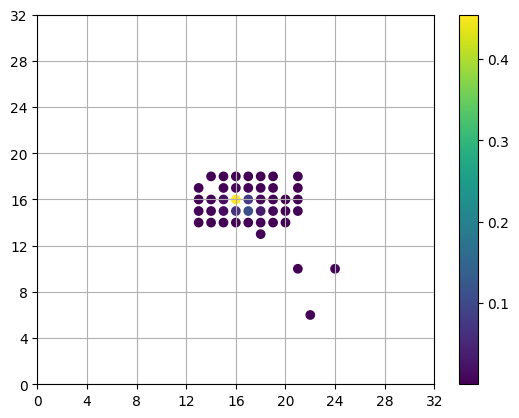

In [14]:
idx = 86
image = x[idx]
image = image.reshape(32,32)
image = torch.tensor(image)
x_hit,y_hit = torch.nonzero(image,as_tuple=True)
energy = image[x_hit, y_hit]

sc = plt.scatter(y_hit,x_hit, c = energy)
plt.colorbar(sc)
check=np.arange(0,36,4)
plt.xticks(check)
plt.yticks(check)
plt.grid()

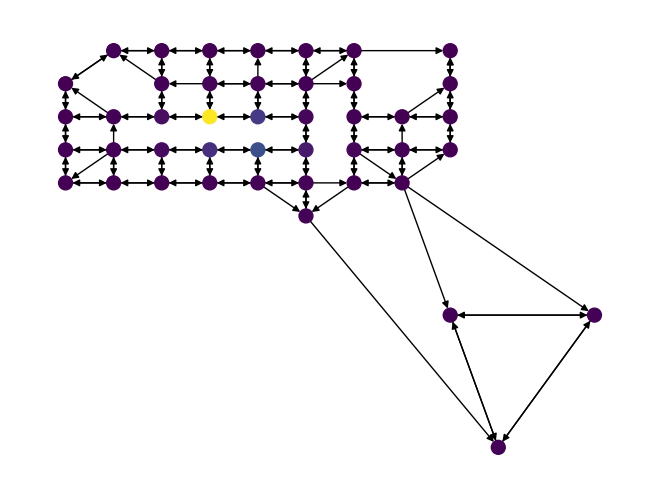

In [8]:
nx_graph = geom.utils.to_networkx(graphs[idx])
nx_graph.remove_edges_from(nx.selfloop_edges(nx_graph))
nodes = list(nx_graph.nodes)
values = graphs[idx].pos
pos = {nodes[i]: tuple(values[i].numpy())[::-1] for i in range(len(nodes))}
energy_values = (graphs[idx].x[:,2]/50).numpy()

nx.draw(nx_graph, pos =pos, node_color=energy_values, node_size=100)

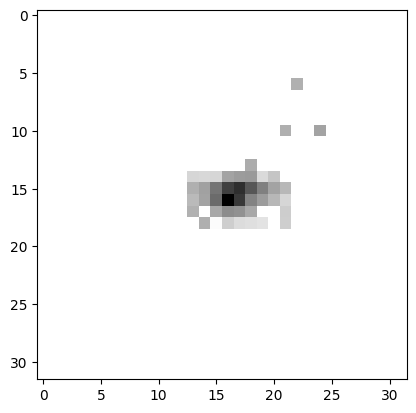

In [9]:
plt.imshow(x[idx], cmap='binary', norm='log')